In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.arima_process import ArmaProcess

In [3]:
from tqdm import tqdm_notebook

In [4]:
from itertools import product

In [5]:
np.random.seed(42)
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])
ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [6]:
ADF_result = adfuller(ARMA_1_1)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.429878682042698
p-value: 1.707846668009623e-08


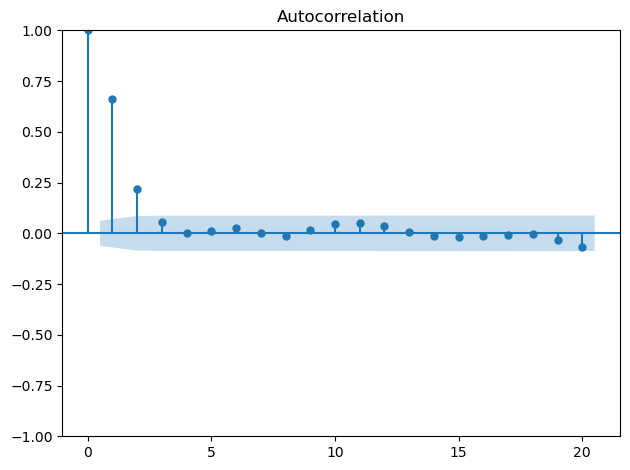

In [7]:
plot_acf(ARMA_1_1, lags=20)
plt.tight_layout()

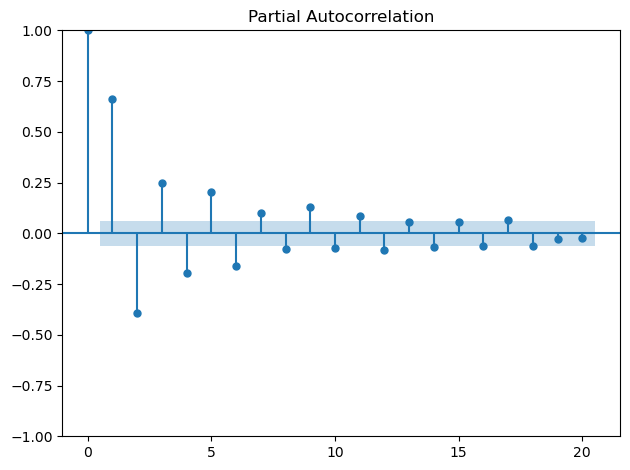

In [8]:
plot_pacf(ARMA_1_1, lags=20)
plt.tight_layout()

In [9]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [10]:
from typing import Union

In [11]:
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), 
                            simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [12]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.098910
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


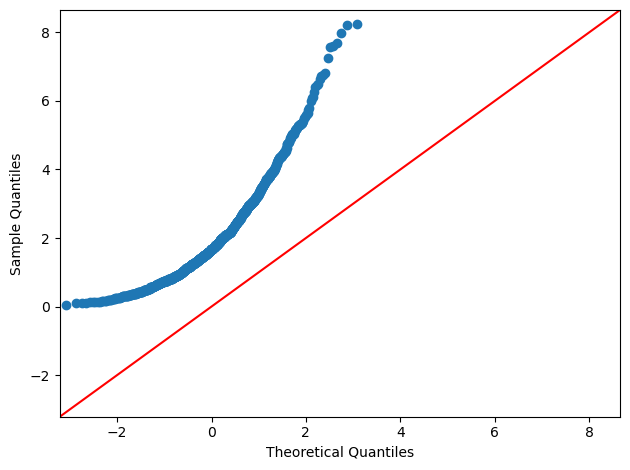

In [13]:
from statsmodels.graphics.gofplots import qqplot
gamma = np.random.default_rng().standard_gamma(shape=2, size=1000)
qqplot(gamma, line='45')
plt.tight_layout()

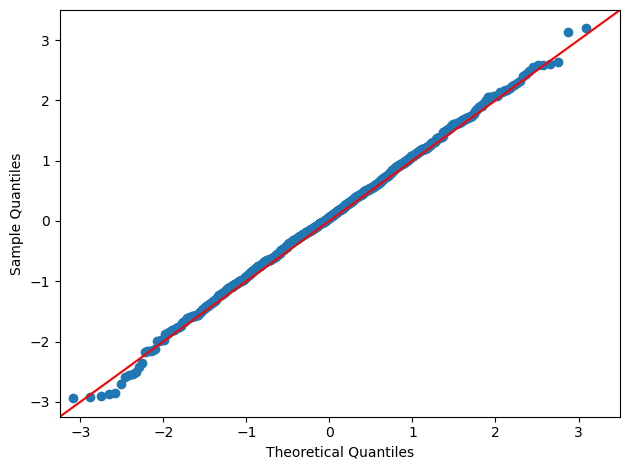

In [14]:
normal = np.random.normal(size=1000)
qqplot(normal, line='45')
plt.tight_layout()

performing residuals analysis

In [15]:
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

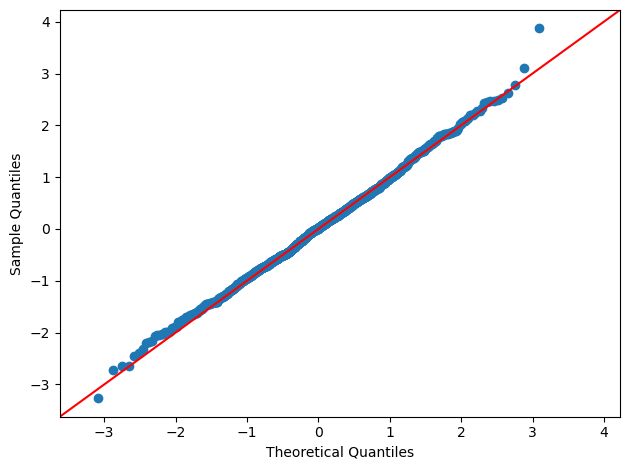

In [16]:
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line='45')
plt.tight_layout()

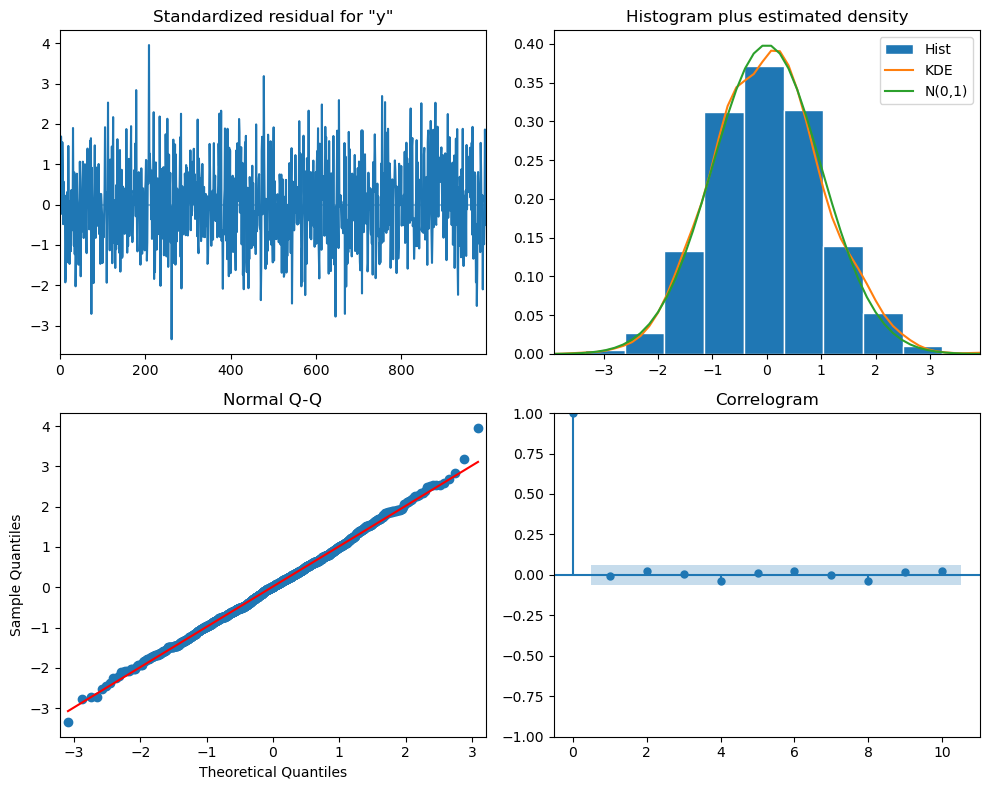

In [17]:
model_fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()

In [18]:
from statsmodels.stats.diagnostic import acorr_ljungbox
results = acorr_ljungbox(residuals, lags=np.arange(1, 11), return_df=True)
print(results['lb_pvalue'])  # 打印每个滞后下的 p-value

1     0.860897
2     0.767966
3     0.909817
4     0.721089
5     0.810385
6     0.821750
7     0.894063
8     0.817501
9     0.852419
10    0.874093
Name: lb_pvalue, dtype: float64


applying the general modeling procedure

In [19]:
df = pd.read_csv("C:/Users/jay/TimeSeriesForecastingInPython-master/data/bandwidth.csv")

In [20]:
df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


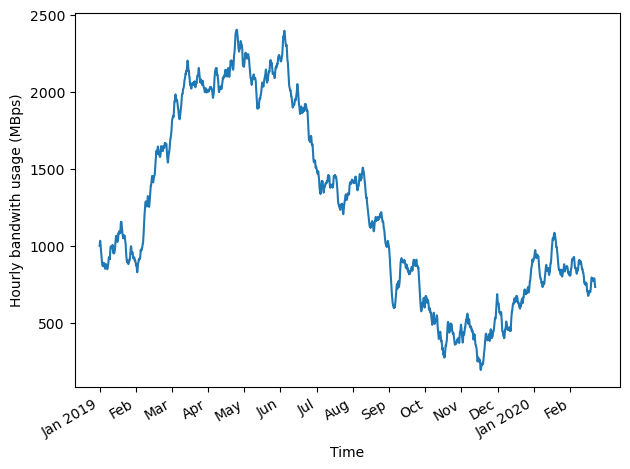

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')
plt.xticks(np.arange(0, 10000, 730),
           ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
            'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])
fig.autofmt_xdate()
plt.tight_layout()

In [22]:
ADF_result = adfuller(df['hourly_bandwidth'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8714653199451994
p-value: 0.7972240255014788


In [23]:
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)

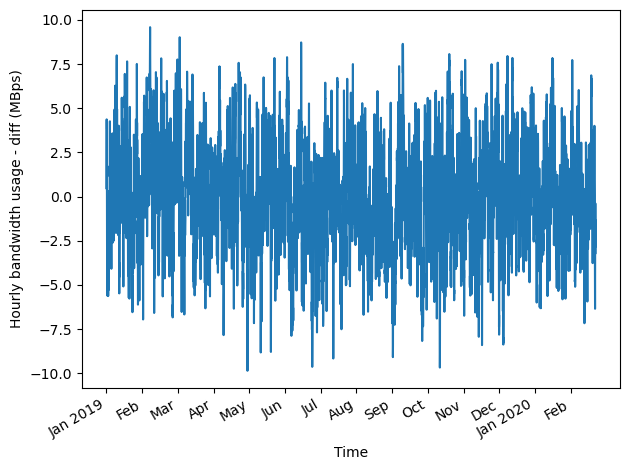

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(bandwidth_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth usage - diff (MBps)')
plt.xticks(np.arange(0, 10000, 730),
           ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
            'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])
fig.autofmt_xdate()
plt.tight_layout()

In [25]:
ADF_result = adfuller(bandwidth_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.694853863789028
p-value: 0.0


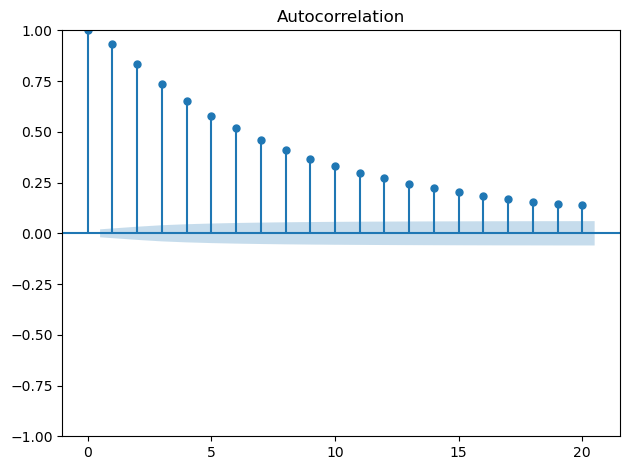

In [26]:
plot_acf(bandwidth_diff, lags=20)
plt.tight_layout()

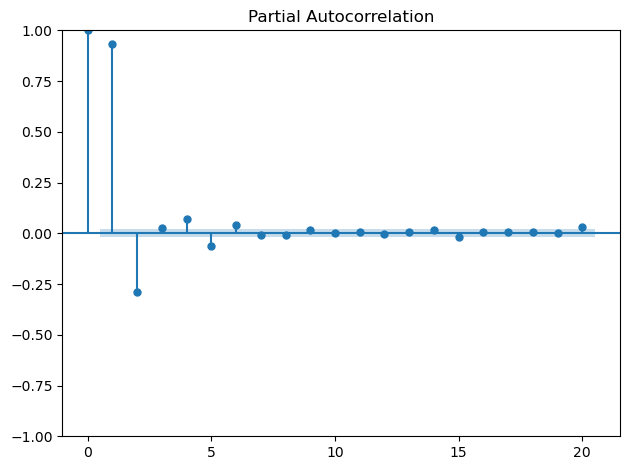

In [27]:
plot_pacf(bandwidth_diff, lags=20)
plt.tight_layout()

In [28]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})
train = df_diff[:-168]
test = df_diff[-168:]
print(len(train))
print(len(test))

9831
168


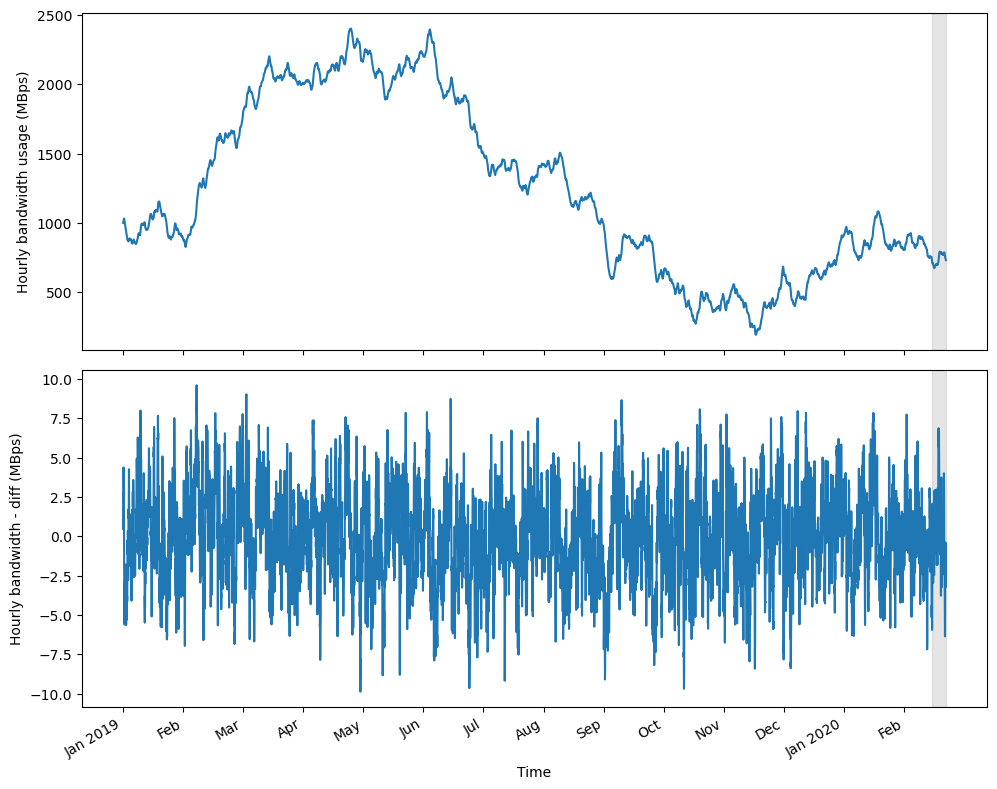

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))
ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth usage (MBps)')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax2.plot(df_diff['bandwidth_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth - diff (MBps)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 10000, 730),
           ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
            'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [30]:
from typing import Union
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), 
                            simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [31]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [32]:
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


In [33]:
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13990.802
Date:                Sun, 04 May 2025   AIC                          27991.604
Time:                        14:50:27   BIC                          28027.570
Sample:                             0   HQIC                         28003.788
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

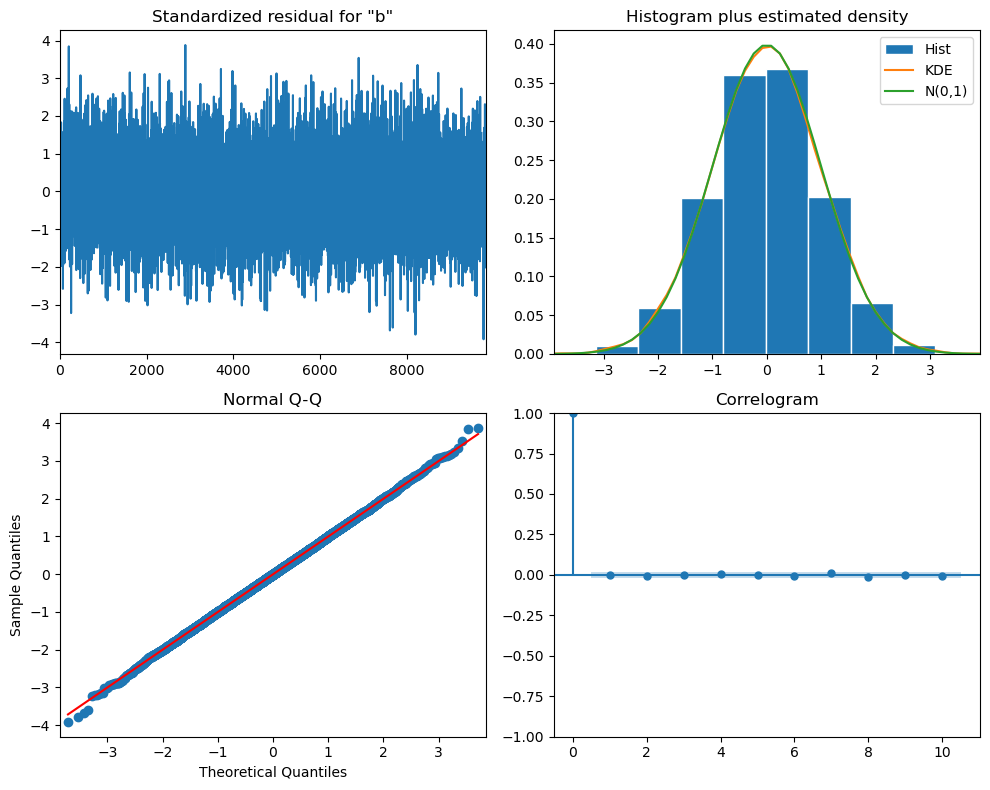

In [34]:
model_fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()

In [35]:
residuals = model_fit.resid
results = acorr_ljungbox(residuals, lags=np.arange(1, 11), return_df=True)
print(results['lb_pvalue'])  # 打印每个滞后下的 p-value

1     0.837257
2     0.811247
3     0.914416
4     0.931545
5     0.973678
6     0.981019
7     0.952607
8     0.919067
9     0.953615
10    0.964015
Name: lb_pvalue, dtype: float64


forecasting bandwidth usage

In [36]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int,
                     method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
        
    elif method =='last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value

    elif method == 'ARMA':
        pred_ARMA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i+window-1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)

        return pred_ARMA

In [37]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:,'pred_mean'] = pred_mean
test.loc[:,'pred_last_value'] = pred_last_value
test.loc[:,'pred_ARMA'] = pred_ARMA

test.head()

,bandwidth_diff,pred_mean,pred_last_value,pred_ARMA
9831,-5.943995,-0.028214,-5.791207,-5.460661
9832,-5.865194,-0.028214,-5.791207,-4.890626
9833,-3.197066,-0.029410,-5.865194,-5.335905
9834,-1.090197,-0.029410,-5.865194,-4.751731
9835,0.665291,-0.029840,-1.090197,-0.375596


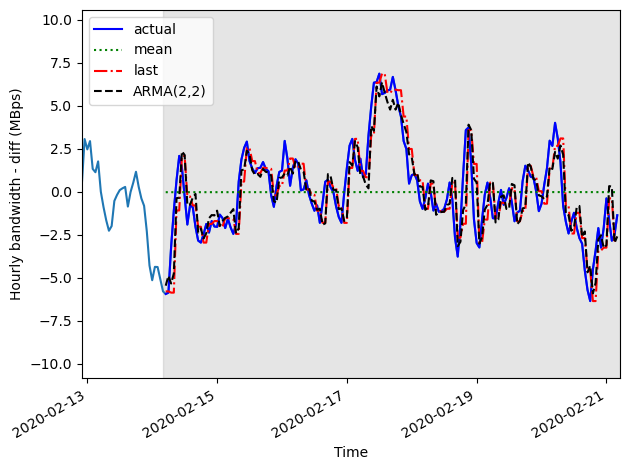

In [40]:
fig, ax = plt.subplots()
ax.plot(df_diff['bandwidth_diff'])
ax.plot(test['bandwidth_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')
ax.axvspan(9830, 9999, color='#808080', alpha=0.2)
ax.set_xlim(9800, 9999)
plt.xticks([9802, 9850, 9898, 9946, 9994],
           ['2020-02-13', '2020-02-15', '2020-02-17',
            '2020-02-19', '2020-02-21'])
fig.autofmt_xdate()
plt.tight_layout()

In [41]:
mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])
print(mse_mean, mse_last, mse_ARMA)

6.306526957989325 2.2297582947733656 1.7690462114507555


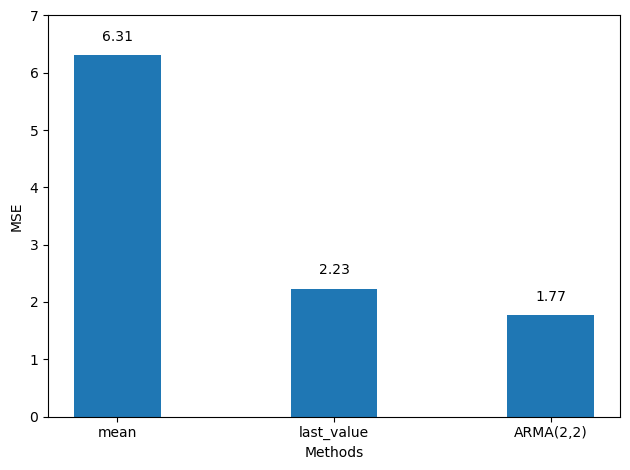

In [42]:
fig, ax = plt.subplots()
x = ['mean', 'last_value', 'ARMA(2,2)']
y = [mse_mean, mse_last, mse_ARMA]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 7)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')
plt.tight_layout()

In [43]:
df['pred_bandwidth'] = pd.Series()

In [44]:
df

,hourly_bandwidth,pred_bandwidth
0,1000.496714,NaN
1,1000.969408,NaN
2,1002.046019,NaN
3,1004.702118,NaN
4,1007.447816,NaN
...,...,...
9995,740.546059,NaN
9996,738.906228,NaN
9997,736.057995,NaN
9998,733.559640,NaN


In [45]:
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] +\
test['pred_ARMA'].cumsum()

In [46]:
df

,hourly_bandwidth,pred_bandwidth
0,1000.496714,NaN
1,1000.969408,NaN
2,1002.046019,NaN
3,1004.702118,NaN
4,1007.447816,NaN
...,...,...
9995,740.546059,721.377109
9996,738.906228,721.70246
9997,736.057995,721.996748
9998,733.559640,719.020898


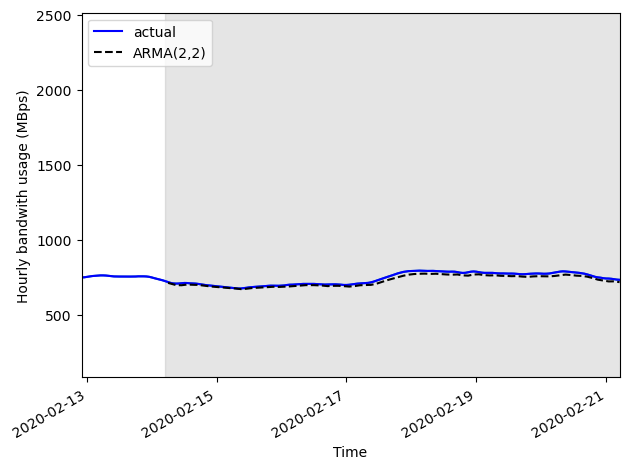

In [47]:
fig, ax = plt.subplots()
ax.plot(df['hourly_bandwidth'])
ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')
ax.axvspan(9831, 10000, color='#808080', alpha=0.2)
ax.set_xlim(9800, 9999)
plt.xticks([9802, 9850, 9898, 9946, 9994],
           ['2020-02-13', '2020-02-15', '2020-02-17',
            '2020-02-19', '2020-02-21'])
fig.autofmt_xdate()
plt.tight_layout()

In [48]:
mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], 
                                      df['pred_bandwidth'][9832:])
print(mae_ARMA_undiff)

14.00036277352635
